# Visualizing Baseball At-Bat Pitching Sequences 
## Clayton Kershaw Against Detroit Tigers

Objective: See Kershaw's pitching sequences against all Tigers' batters on June 20, 2011.

**Questions**: 
1. What is the dominate pitch type thrown by Kershaw?
2. Are the batters mostly batted right or left?

**Context**: 

Clayton Kershaw of the Los Angeles Dodgers is considered one of the best pitchers in the modern baseball era. On June 20, 2011 against the Detroit Tigers, he pitched a shutout game, struck out 11 batters.

In this mini project, we seek to visualize Kershaw's pitches for all at bats and see if we can see gain some insights from the plots.

The inspiration originates from a Udemy course: *Pitch Location Charts with PITCHf/x and ggplot*. In that course, the instructor looked at Max Scherzer's no-hitter performance against the Pittsburgh Pirates on June 20, 2015.

PITCHf/x data provides valuable information such as resulting ball location in catcher's frame. 

We will accomplish the visualization tasks using *R* and libraries such as pitchRx, ggplot2, dplyr, and adopt or modified the code used in that course. 

In [1]:
# Load major libary 
library(pitchRx)
library(dplyr)
library(ggplot2)

Warning message:
"package 'pitchRx' was built under R version 3.5.2"Loading required package: ggplot2

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [2]:
# Retrieve and load game data
bdat <- scrape(game.ids="gid_2011_06_20_detmlb_lanmlb_1")
atbat <- bdat$atbat
pitch <- bdat$pitch

If file names don't print right away, please be patient.


http://gd2.mlb.com/components/game/mlb/year_2011/month_06/day_20/gid_2011_06_20_detmlb_lanmlb_1/inning/inning_all.xml 


In [3]:
# Inner join relevant features to look at pitches
so <- inner_join(atbat,pitch, by="num")%>%
  filter(inning_side.x =='top')%>%
  select(num,start_tfs,stand,event,inning.x,batter_name,des,tfs,start_speed,px,pz,pitch_type)

print(dim(so))

[1] 112  12


In [4]:
# Define strike zone that will be incorporated using ggplot geom_path
x <-c(-.95,.95,.95,-.95,-.95)
z <-c(1.6,1.6,3.5,3.5,1.6)
sz <- data.frame(x,z)

In [5]:
# Types of pitches Kershaw threw
unique(so$pitch_type)

[1] "FF" "CH" "SL" "CU"

In [5]:
# Spell out the pitch type
temp <- so$pitch_type
temp[which(temp=='FF')]<-'fastball'
temp[which(temp=='CU')]<-'curveball'
temp[which(temp=='CH')]<-'changeup'
temp[which(temp=='SL')]<-'slider'
so$pitch_description <- temp

In [6]:
# Setting the leves so the pitch label colors will be consistent from figure to figure
so$pitch_description<-factor(so$pitch_description,levels=c("fastball","changeup","slider","curveball"))


In [7]:
# To make sure we label batter's stand (right or left) properly
stand_xcoord <-so$stand
stand_xcoord[which(stand_xcoord =='R')] <- -1.5
stand_xcoord[which(stand_xcoord =='L')] <- 1.5
stand_xcoord <- as.numeric(stand_xcoord)
so$stand_xcoord <- stand_xcoord
so$stand<-factor(so$stand,levels=c('R','L'))

# To make sure we know how the sequence of pitches against a batter ends
des <- so$des
indices<- which(des=='In play, out(s)')
event <- so$event
des[indices] <- event[indices]
so$des2 <- des

# To arrange the data so the pitches are sorted based time.
so<- so%>%
  arrange(tfs)

# To create pitch counts for each at bat.
temp <- so %>% group_by(num) %>%
  summarize(num_of_pitches = n())

so$pitch_enum <- unlist(lapply(temp$num_of_pitches,seq))


Warning message:
"Removed 4 rows containing missing values (geom_point)."

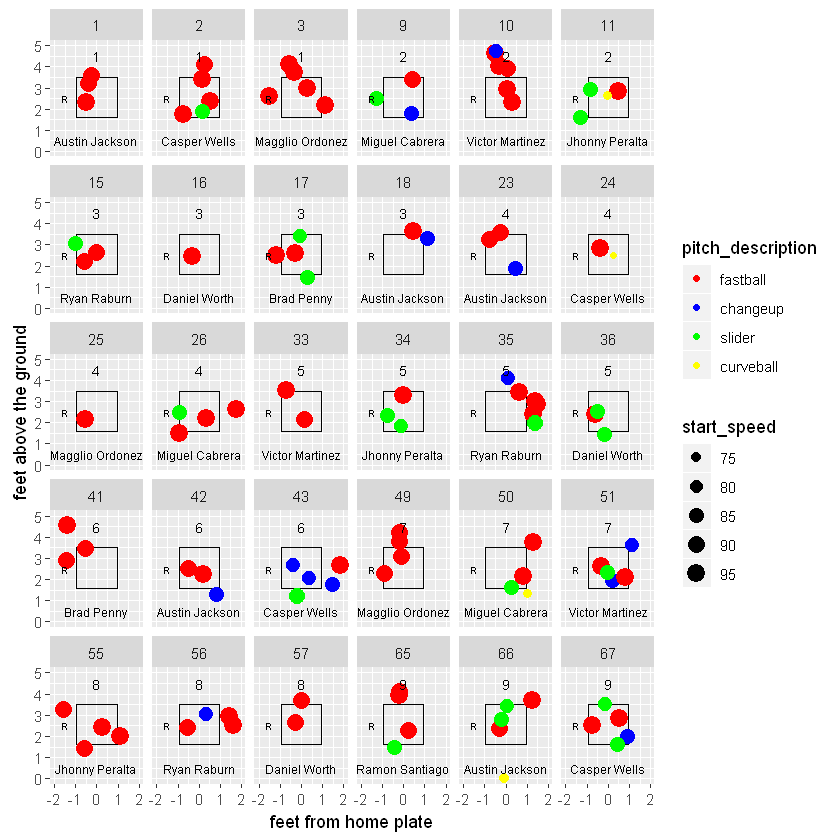

In [9]:
# Plot every batter Kershaw faced using ggplot2's facet
colors <- c('red','blue','green','yellow')
names(colors) <-c('fastball','changeup','slider','curveball')
pitches = unique(so$pitch_description)
zmax <- (max(so$start_speed)-75.4)/22
zmin <- (min(so$start_speed)-75.4)/22
p = ggplot()+
geom_path(data=sz,aes(x=x,y=z))+
coord_equal()+
xlab('feet from home plate')+
ylab('feet above the ground')+
geom_point(data=so,aes(x=px,y=pz,size=start_speed,color=pitch_description))+
scale_size(range=c(3*zmin+2,3*zmax+2))+
scale_color_manual(values=colors[pitches])+
facet_wrap(~num)+ 
geom_text(data=so,aes(label=stand,x=stand_xcoord),y=2.5,size=2)+
geom_text(data=so,aes(label=batter_name),x=0,y=.5,size=2.5)+
geom_text(data=so,aes(label=inning.x),x=0,y=4.5,size=3)+
xlim(-2,2)+
ylim(0,5)
print(p)

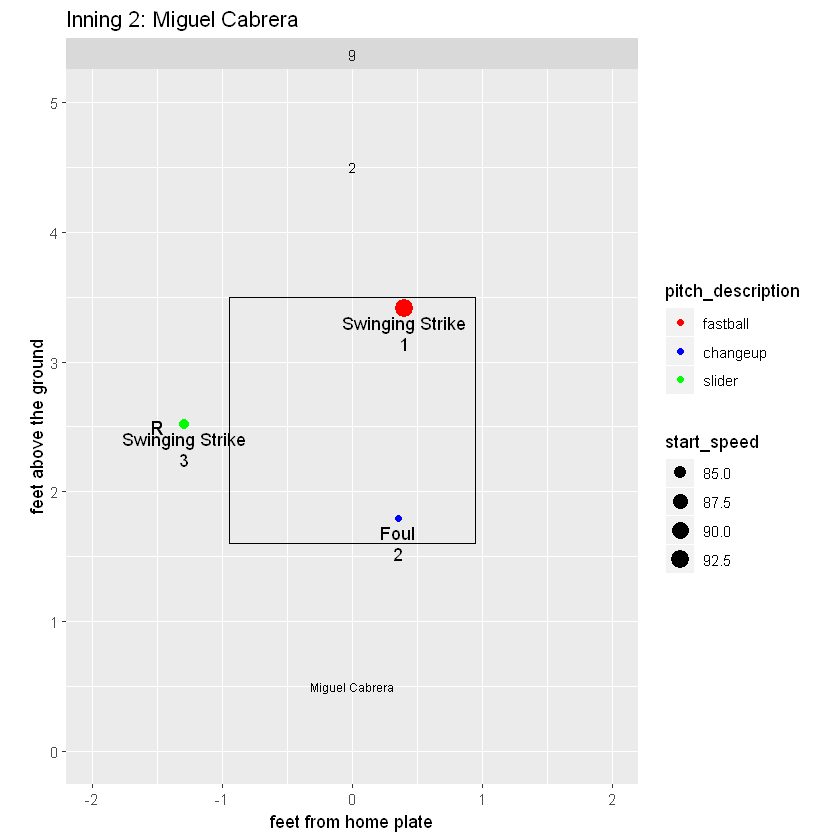

In [10]:
# We can also plot just at bat against a batter

batter = 'Miguel Cabrera'
inning = 2

ab <- so %>% filter(batter_name == batter, inning.x == inning)
ggplot()+
geom_path(data=sz,aes(x=x,y=z))+
coord_equal()+
xlab('feet from home plate')+
ylab('feet above the ground')+
geom_point(data=ab,aes(x=px,y=pz,size=start_speed,color=pitch_description))+
scale_size(range=c(3*zmin+2,3*zmax+2))+
scale_color_manual(values=colors[pitches])+
facet_wrap(~num)+ 
geom_text(data=ab,aes(label=stand,x=stand_xcoord),y=2.5,size=4)+
geom_text(data=ab,aes(label=batter_name),x=0,y=.5,size=2.5)+
geom_text(data=ab,aes(label=inning.x),x=0,y=4.5,size=3)+
xlim(-2,2)+
ylim(0,5)+
ggtitle(paste("Inning ",inning, ": ",batter,sep=""))+
geom_text(data=ab,aes(label=des2,x=px,y=pz),vjust=1.5)+
geom_text(data=ab,aes(label=pitch_enum,x=px,y=pz),vjust=3)

## Observations

At the time of this game, Kershaw was *23*, a young player considered in the major league. The plots show that 

* Majority of the pitches are fastballs, and 
* **Only** three curveballs were thrown during the game.
* **ALL** batters Kershaw faced in the game batted right handed. Perhaps as a left-hand pitcher, Kershaw had advantage over batters batted right handed. 

![](kershaw.jpg) 


Instead of having all the at-bats plots together, we can generate them one by one and piece them together as a slideshow. The code below generates plot per at bat.

In [18]:
colors <- c('red','blue','green','yellow')
names(colors) <-c('fastball','changeup','slider','curveball') # To make sure pitch type colors are the same for all figures
for (i in unique(so$num)){
    ab <- so%>% filter(num==i)
    batter = ab$batter_name[1]
    inning = ab$inning.x[1]
    pitches = unique(ab$pitch_description)
    zmax <- (max(ab$start_speed)-75.4)/22
    zmin <- (min(ab$start_speed)-75.4)/22
    plot <- ggplot()+
      geom_path(data=sz,aes(x=x,y=z))+
      coord_equal()+
      xlab('feet from home plate')+
      ylab('feet above the ground')+
      geom_point(data=ab,aes(x=px,y=pz,size=start_speed,color=pitch_description))+
      scale_size(range=c(3*zmin+2,3*zmax+2))+
      scale_color_manual(values=colors[pitches])+
      #facet_wrap(~num)+ 
      geom_text(data=ab,aes(label=stand,x=stand_xcoord),y=2.5,size=5)+
      #geom_text(data=ab,aes(label=batter_name),x=0,y=.5,size=4)+
      #geom_text(data=ab,aes(label=inning.x),x=0,y=4.5,size=4)+
      xlim(-2,2)+
      ylim(0,5)+
      ggtitle(paste("Inning ",inning, ": ",batter,sep=""))+
      geom_text(data=ab,aes(label=des2,x=px,y=pz),vjust=1.5)+
      geom_text(data=ab,aes(label=pitch_enum,x=px,y=pz),vjust=3)
    
    ggsave(paste('atbat',i,'.png',sep=''), plot)

}

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_point)."Warning message:
"Removed 1 rows containing missing values (geom_text)."Warning message:
"Removed 1 rows containing missing values (geom_text)."Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_point)."Warning message:
"Removed 1 rows containing missing values (geom_text)."Warning message:
"Removed 1 rows containing missing values (geom_text)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_point)."Warning message:
"Removed 1 rows containing m